# Restaurant recommendation system based on collaborative filtering

### In this project, we create a recommendation system based on collaborative filtering. The model will recommend a user for a restaurant based on his and other users past experiences and in all the restaurants that are in the data set.
## Collaborative Filtering 
###The goal of  Collaborative Filtering based (CF) algorithms is to provide item recommendations or prediction based on user's previous likings and opinion of other like-minded users. The opinions of users can be obtained explicitly from the users or by some implicit measures.In the typical CF scenario, there is a list of m users U={u1,u2,..,um} and the list of n items I={I1,I2,..,Im}. which the user has expresses his opinions about. Opinions cab be given by a user as a rating score (in out case this is the stars column). There exists a distinguished user ua belong U for whom the task of CF algorithm is to find an item likeliness that can be of two forms prediction and recommendation. Prediction is numerical value P expressing the predicted likeliness of item for the active user. Recommendation is a list of N items that the active user will like the most. 
### There two different  CF algorithms user-based and item-based. User-based algorithms utilize entire user-item data to generate prediction. The idea is to find out a set of users (known as neighbours), that have a history of agreeing with the target user. Once such a set is formed, the system uses an algorithm to combine the preferences of neighbors to produce a prediction or top-N recommendations for active user. In contrast, Item based approach looks into the set of items the target user has rated and computes how similar they are to the target item i and then select k most similar items {i1,i2,..,ik}. At the same time their corresponding similarities {s1,s2,..,sik} are also computed. 


In [8]:
#Uploading necessary libraries
%matplotlib inline
from collections import defaultdict 
import json #data transfering 

import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl


from scipy.stats.stats import pearsonr

from operator import itemgetter
import os 


### Definding the size of the figures that we need in data analisys as well as color scheem, color style, font type  etc.



In [9]:
#figure characteristics
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 8)
rcParams['figure.dpi'] = 120
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


### Minimize chartjunk by stripping out unnecesary plot borders and axis ticks. The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn.

In [10]:
def remove_border(axes=None,top=False,right=False,left=True,bottom=True):
    ax=axes or pl.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    #now re-enable visible 
    
    if top:
        ax.xaxis.tick_top()
        
    if bottom:
        ax.xaxis.tick_bottom()
    """    
    if left:
        ax.xaxis.tick_left()
        
    if right:
        ax.xaxis.tick_right()
    """    


### 1. Loading the data
### Data set contains the costomer id's (user_id) and restaurant id's (business_id) and corresponding scores that were given to each particular restaurant (stars). 

In [11]:
pd.set_option('display.width',500)
pd.set_option('display.max_columns',100)

os.chdir(r'E:\Andrey\Stanford\PythonClass')
fulldf=pd.read_csv("bigdf.csv")
fulldf.head()

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57
2,mlBC3pN9GXlUUfQi1qBBZA,9yKzy9PApeiPPOUJEtnvkg,2010-07-05 00:00:00,W8CX2h_hmODWmgSJVbMifw,2,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.702381,84
3,0bNXP9quoJEgyVZu9ipGgQ,9yKzy9PApeiPPOUJEtnvkg,2012-10-10 00:00:00,nYVQiPGeiwr7g5BSX7WDJg,3,9,Aileen,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.180077,261
4,T7J9ae0wTskrI_Bgwp-4cA,9yKzy9PApeiPPOUJEtnvkg,2009-12-17 00:00:00,grZNCXAgd-OH8daA28R-2A,3,1,Jasmine,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.343284,201


### 2.Exploratory data analysis:
####   a. The numebr of users

In [12]:
fulldf.user_id.count()

149319

In [13]:
fulldf.business_id.unique()

array(['9yKzy9PApeiPPOUJEtnvkg', '8m08a9xJKmANwmeuR-0bPA',
       'r3r_bAfa6pZKIhQB82FizQ', ..., 'dUJMmr6TFrHmiokijXiyUg',
       'ZRqpSeZEw6sy8r01TdCudQ', 'fgZ2zBACNGcRwyTGCNHWdg'], dtype=object)

#### b. The number of unique restaurants 

In [14]:
len(fulldf.business_id.unique ())

4503

#### c. The average number of reviews per user 


In [15]:
fulldf[['user_id','review_id']].groupby('user_id').count().mean()

review_id    4.292133
dtype: float64

####Summary:

In [16]:
print "Number of reviews:", fulldf.user_id.count()
print "Number unique items:", len(fulldf.business_id.unique())
print "Numebr of reviews per item:",(0.0+fulldf.business_id.count())/len(fulldf.business_id.unique())
print "Number of reviews per user:",(0.0+fulldf.user_id.count())/len(fulldf.user_id.unique())


Number of reviews: 149319
Number unique items: 4503
Numebr of reviews per item: 33.1598934044
Number of reviews per user: 4.29213257064


### From our calculation we see that the average number of reviews per item is near 9 times higher than the average number of reviews per user, pointing out that we have more avaliable data for items based approach rather than for user-based one and it would be reasonalbe to go for item-based approach. Let's take a look at distribution of unique user reviews and item (restaurant) reviews:



<function matplotlib.pyplot.show>

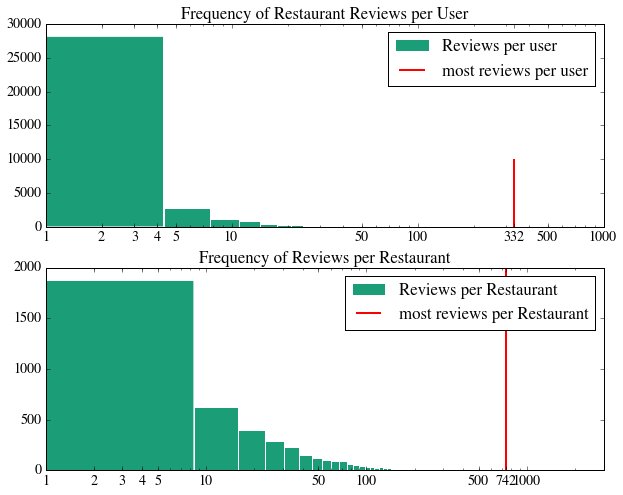

In [17]:
#Making a histograms
fig=pl.figure()

#plot histogram for reviews per user
ax=fig.add_subplot(2,1,1)
num_reviews_per_user=[numver for numver in fulldf['user_id'].value_counts()]

#print num_reivews peruser
ax.set_title('Frequency of Restaurant Reviews per User')
ax.hist(num_reviews_per_user,bins=100, label='Reviews per user')

#scale review count as logarithmic
ax.set_xscale('log')

#add ticks,lablels,ect.
ax.set_xlim(0,1000)
ax.set_xticks([1,2,3,4,5,10,50,100,max(num_reviews_per_user),500,1000])
ax.set_xticklabels([1,2,3,4,5,10,50,100,max(num_reviews_per_user),500,1000], horizontalalignment='center')
ax.set_yscale('linear')

maxline = ax.vlines(max(num_reviews_per_user), 1, 10000, colors='red', label='most reviews per user')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)



ax=fig.add_subplot(2,1,2)
num_reviews_per_user=[numver for numver in fulldf['business_id'].value_counts()]

# plot histogram for reviews per user
ax.set_title('Frequency of Reviews per Restaurant')
ax.hist(num_reviews_per_user,bins=100, label='Reviews per Restaurant')


#scale review count as logarithmiic
ax.set_xscale('log')

##add ticks,lablels,ect
ax.set_xlim(1,3000)
ax.set_xticks([1,2,3,4,5,10,50,100,max(num_reviews_per_user),500,1000])
ax.set_xticklabels([1,2,3,4,5,10,50,100,max(num_reviews_per_user),500,1000], horizontalalignment='center')

ax.set_yscale('Linear')
ax.set_ylim(1,2000)

maxline = ax.vlines(max(num_reviews_per_user), 1, 10000, colors='red', label='most reviews per Restaurant')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

pl.show






### The distribution of reviews per users shows that many of the users gave around  4 reviews in general and that there are more restaurant with higher reviews, supporting our conclussion about low data content for user-user based filtering approach. 


In [18]:
# find out if there more  users or more items
if len(fulldf['user_id'].drop_duplicates())>len(fulldf['business_id'].drop_duplicates()):
    print 'more users than joints'
else:
    print 'more joints than users'
    


more users than joints


###Also there are more unique users than restaurants, so we do have more data on restaurants rather than on users. The following step is to exclude low reviews users and low reviews items from data set to make our future prediction more relaible 


In [19]:
# supportive calcualtions
print "Averaging  all ratings of resturants:", round(fulldf.stars.mean(),2)
means_by_Join=fulldf[['business_id','stars']].groupby('business_id').mean()
means_by_Join1=fulldf[['business_id','stars']].groupby('business_id')
print 'Averaging ratings across each resturant agregated rating:'
means_by_Join['stars'].mean()


Averaging  all ratings of resturants: 3.74
Averaging ratings across each resturant agregated rating:


3.4612130229428746

### Following function adds two columns containing average values of business_id count and user_id

In [20]:
#Lets make two separate chunk of data based on user and on items
def recompute_frame(ldf):
    #ldf=fulldf.copy()
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')

    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()

    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    
    nldf=ldf.copy()
    nldf.set_index(['business_id'],inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)



    nldf.set_index(['user_id'],inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    
    return nldf

### To exclude the data containing low reviews we subset only those datathat have  more that 60 users reviews and 150 reviwes for restaurants.  

In [21]:
copydf=fulldf.copy()
# based on the Graph we found that most of the time people give a few reviewes to resturants
copydf=recompute_frame(copydf)

smalldf=copydf[(copydf.user_review_count>60)&(copydf.business_review_count>150)]
smalldf=recompute_frame(smalldf)

In [22]:
print "Number of unique restaurants:", smalldf.business_id.drop_duplicates().count()
print "Number of unique users:", smalldf.user_id.drop_duplicates().count()

Number of unique restaurants: 172
Number of unique users: 240


In [23]:
print "Number of reviews:", smalldf.user_id.count()
print "Number unique items:", len(smalldf.business_id.unique())
print "Numebr of reviews per item:",(0.0+smalldf.business_id.count())/len(smalldf.business_id.unique())
print "Number of reviews per user:",(0.0+smalldf.user_id.count())/len(smalldf.user_id.unique())


Number of reviews: 6165
Number unique items: 172
Numebr of reviews per item: 35.8430232558
Number of reviews per user: 25.6875


###The unique number of users and items shrunk down to 240 and 172 respectively. The average number of items and users became higher. Let's take a look at the new distribution of reviews per items and per user

<function matplotlib.pyplot.show>

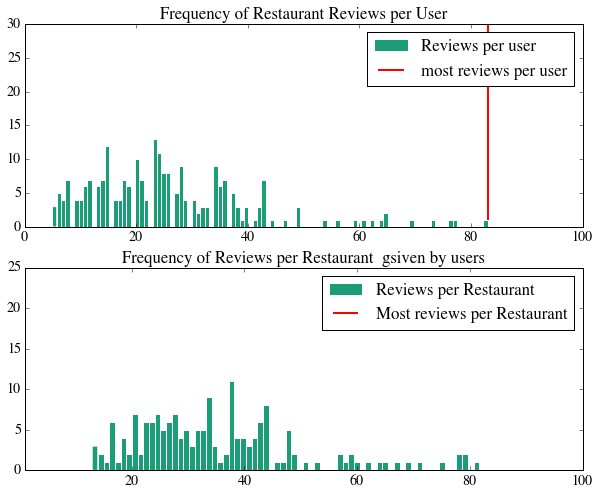

In [24]:
#Making a histograms for 
fig=pl.figure()

#plot histogram for reviewa per user
ax=fig.add_subplot(2,1,1)
num_reviews_per_user=[numver for numver in smalldf['user_id'].value_counts()]

#print num_rivewa_per_user
ax.set_title('Frequency of Restaurant Reviews per User')
ax.hist(num_reviews_per_user,bins=100, label='Reviews per user')

#scale review count as logarithmiic
ax.set_xscale('linear')

#add ticks,lablels,ect
ax.set_xlim(0,100)
ax.set_ylim(0,30)

#ax.set_xticks([0,20,40,50,60,100,max(num_reviews_per_user)])
#ax.set_xticklabels([1,2,3,4,5,10,50,100,max(num_reviews_per_user)], horizontalalignment='center')
ax.set_yscale('linear')

maxline = ax.vlines(max(num_reviews_per_user), 1, 10000, colors='red', label='most reviews per user')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)



ax=fig.add_subplot(2,1,2)
num_reviews_per_user=[numver for numver in smalldf['business_id'].value_counts()]

# plot histogram for reviews per user
ax.set_title('Frequency of Reviews per Restaurant  gsiven by users')
ax.hist(num_reviews_per_user,bins=100, label='Reviews per Restaurant')


#scale review count as logarithmiic
ax.set_xscale('linear')

##add ticks,lablels,ect
ax.set_xlim(1,100)
#ax.set_xticks([1,2,3,4,5,10,50,100,max(num_reviews_per_user),])
#ax.set_xticklabels([1,2,3,4,5,10,50,100,max(num_reviews_per_user)], horizontalalignment='center')

ax.set_yscale('linear')
ax.set_ylim(0,25)

maxline = ax.vlines(max(num_reviews_per_user), 1, 10000, colors='red', label='Most reviews per Restaurant')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

pl.show

Average User Rating


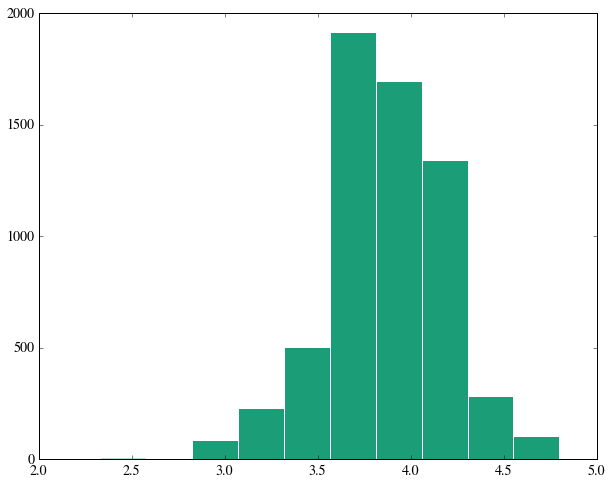



Average Business Rating

Overall mean: 3.868


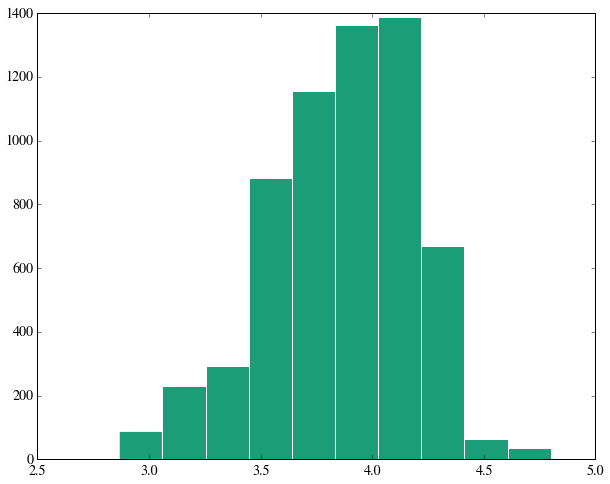

In [25]:
print 'Average User Rating'
plot=pl.hist(smalldf.user_avg)
pl.show()

print '\n'

print 'Average Business Rating'
plot= pl.hist(smalldf.business_avg)
pl.show

print '\nOverall mean:', round(smalldf.stars.mean(),3)

###To clalcuate similarity between items and to select the most smililar items we need to first isolate the users who have rated both of these items and then to apply a  similarity computation technique to determine the similarity for each pair of items. 

In [26]:
#Get the resturant 1 and 2 and find out common users who will give reviews to those restuants

restaurants=smalldf.business_id.unique()

support=[]
for i,rest1 in enumerate(restaurants):
    for j,rest2 in enumerate(restaurants):
        if i<j:
            rest1_reviweres=smalldf[smalldf.business_id==rest1].user_id.unique()
            rest2_reviweres=smalldf[smalldf.business_id==rest2].user_id.unique()
            common_reviweres=set(rest1_reviweres).intersection(rest2_reviweres)
            support.append(len(common_reviweres))

#what is the number of common users for these two pairs of resturants?
print "Mean support is:", np.mean(support)


Mean support is: 6.84679722562


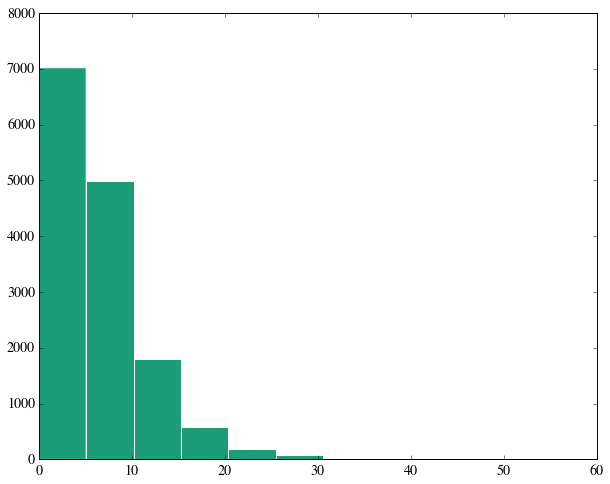

In [27]:
plot=pl.hist(support)
pl.show()


### The average number of users rated common resturants across all pairs of restaurants is 6.8. From practical point of view this number is low and even we put so much constrains on the data we still have a little data to build up very reliable collaborative system based on similarity. Nevertheless let's calculate similarity for each pair and make a Database containing all of them.  


###In this case we will use correlation-based similarity. It's measured by computing the Pearson correlation between two items (in our case business_id):


In [28]:

def pearsonr_sim(rest1_reviews,rest2_reviews,n_common):
    if n_common==0:
        rho=0.
    else:
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        rho=pearsonr(diff1,diff2)[0]
    return rho

def get_rest_rev(restaurant_id,df,set_of_users):
    mask=(df.user_id.isin(set_of_users))&(df.business_id==restaurant_id)
    reviews=df[mask]
    reviews=reviews[reviews.user_id.duplicated()==False]
    return reviews
    
    
def callculate_simmliarity(rest1,rest2,df,sim_func):
    rest1_reviwers=smalldf[smalldf.business_id==rest1].user_id.unique()
    rest2_reviwers=smalldf[smalldf.business_id==rest2].user_id.unique()
    common_reviewers=set(rest1_reviwers).intersection(rest2_reviwers)
    #rest1_reviws=get_rest_rev(rest1,df,common_reviewers)
    #rest2_reviws=get_rest_rev(rest2,df,common_reviewers)
    #sim=sim_func(rest1_reviws,rest2_reviws,len(common_reviewers))
    
    reviews=[get_rest_rev(rest_id,df,common_reviewers) for rest_id in [rest1,rest2]]
    n_common=len(common_reviewers)
    #print (reviews)
    sim=sim_func(reviews[0],reviews[1],n_common)
    
    similarity=sim if (not np.isnan(sim)) else 0.
    return (similarity,n_common)
    
    
        


###Check if the function works:

In [29]:
print 'Correlation between the same items [0]:', callculate_simmliarity(smalldf.business_id[0],smalldf.business_id[0],smalldf,pearsonr_sim)  
print 'Correlation between different items [0]:', callculate_simmliarity(smalldf.business_id[0],smalldf.business_id[210],smalldf,pearsonr_sim)    

Correlation between the same items [0]: (1.0, 25)
Correlation between different items [0]: (-0.69074364197718463, 4)


###Correlation between the same items is 1, as expected. For different items we have different numbers.


###Defining  a class Database and creating the object db (of Database class) containnig simmiliarities of all pairs of restaurants avaliable in database


In [30]:
# biudl up the databae contining all pairs of item-item plus lengs of common user
class Database:
    def __init__(self,df):
        self.database={}
        self.df=df
        #pairs of keys and position of unique business in dictoanry
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys,l_keys],dtype=np.int)
        
        
             
    def populate_by_calculating(self,sim_func):
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1< i2:
                    sim, nsup=callculate_simmliarity(b1,b2,self.df,sim_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                    
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sim[i1][i1]=nsup
                    
# The get function gives us the simliriaties and the number of common users that gives rwvies to the resturnas                    
    def get(self,b1,b2):
        i1=self.uniquebizids[b1] # fins the value associated with this key and store it as index.
        i2=self.uniquebizids[b2] # finds it for another resturand and find the valuse of those rows and coluns
        
        sim=self.database_sim[i1][i2] #findin the simmilarities between two resturans
        sup=self.database_sup[i1][i2]
        
        return (sim,sup)   
    
    
    
db=Database(smalldf)
db.populate_by_calculating(pearsonr_sim)

        
        
    
    
    
    
    


### if the number of reviwers is one then we will get the correlation number one, which is not accurate. We need to get only those items-items simliratires number which more than 1 reviews were given to . For that we intorduce regulatory parameter "reg" which compensate the low reviews pairs buy making thier high correlation value low enough to to be in top 5 choices. 

In [31]:
def shrunk_sim(sim,n_common,reg=3.):
    ssim=sim*(n_common)/(n_common+reg)
    return ssim
#db.database_sim.shape
#np.sort(db.uniquebizids.keys())

### Find out the pairs of items with highest similarities in our data base db

In [32]:
def knearest(restaurant_id, set_of_restaurants,db,k,reg):
    neighbours=[]
    
    for rest in set_of_restaurants:
        
        if rest !=restaurant_id:
            sim,ncom=db.get(restaurant_id,rest)
            shrunken=shrunk_sim(sim,ncom,reg)
            neighbours.append((rest,shrunken,ncom))
            
    neighbours.sort(key=itemgetter(1), reverse=True)
    
    return neighbours[:k]

###let's test or kenearest function for a particular item 

In [33]:
testbizid=smalldf.business_id.ix[0]
testbizid1=smalldf.business_id.ix[210]

In [34]:
knearest(testbizid,smalldf.business_id.unique(),db,10,3)

[('zp713qNhx8d9KCJJnrw1xA', 0.59871444843387689, 6),
 ('MuIXnv7Oq7X3-4aEsp9dDA', 0.5714285714285714, 4),
 ('IuAPYzf3NSyfyXYgT46YVA', 0.52712989094324325, 5),
 ('z3yFuLVrmH-3RJruPEMYKw', 0.51945655565843596, 6),
 ('j7XuypdW_w935NhjbvKPQw', 0.51914014693652932, 5),
 ('mhQCxOiqp03qnhGRTtPduw', 0.49999999999999994, 3),
 ('zOCdVUKUN3b-obT67Qjyww', 0.4676372353077225, 3),
 ('mqQwChPNN4o4DhAzaGntIA', 0.45973235723727096, 4),
 ('KGX7O-_WqOIy9o7u9NOa9A', 0.45139574191708659, 4),
 ('XWvht_1ZLdK7EHJ3jo4q0g', 0.44283378326675649, 4)]

###Make friendly looking interface and for each user_id or business_id provide name of user or name of the respective restaurant.



In [35]:
def bizname_from_id(df,resutrand_id):
    tt=df[(df.business_id==resutrand_id)].biz_name.values[0]
    return  tt

def username_from_id(df,user_id):
    tt=df[df['user_id']==user_id].user_name.values[0]
    return tt



In [36]:
print bizname_from_id(smalldf,testbizid1)

Wildfish Seafood Grille


In [37]:
tops=knearest(testbizid,smalldf.business_id.unique(),db,7,3)
tops

[('zp713qNhx8d9KCJJnrw1xA', 0.59871444843387689, 6),
 ('MuIXnv7Oq7X3-4aEsp9dDA', 0.5714285714285714, 4),
 ('IuAPYzf3NSyfyXYgT46YVA', 0.52712989094324325, 5),
 ('z3yFuLVrmH-3RJruPEMYKw', 0.51945655565843596, 6),
 ('j7XuypdW_w935NhjbvKPQw', 0.51914014693652932, 5),
 ('mhQCxOiqp03qnhGRTtPduw', 0.49999999999999994, 3),
 ('zOCdVUKUN3b-obT67Qjyww', 0.4676372353077225, 3)]

In [38]:
# print everiting in good way 
print "For", bizname_from_id(smalldf,testbizid), ",top maches are:"
for i, (biz_id, sim, nc) in enumerate(tops):
    print i, bizname_from_id(smalldf, biz_id), "sim",sim, "| Support", nc
    
pd.DataFrame(tops)


For Lobbys Beef Burgers Dogs ,top maches are:
0 La Condesa Gourmet Taco Shop sim 0.598714448434 | Support 6
1 Citizen Public House sim 0.571428571429 | Support 4
2 FnB sim 0.527129890943 | Support 5
3 Defalco's Italian Grocery sim 0.519456555658 | Support 6
4 Republic Ramen + Noodles sim 0.519140146937 | Support 5
5 unPhogettable sim 0.5 | Support 3
6 Haus Murphy's sim 0.467637235308 | Support 3


,0,1,2
0,zp713qNhx8d9KCJJnrw1xA,0.598714,6
1,MuIXnv7Oq7X3-4aEsp9dDA,0.571429,4
2,IuAPYzf3NSyfyXYgT46YVA,0.527130,5
3,z3yFuLVrmH-3RJruPEMYKw,0.519457,6
4,j7XuypdW_w935NhjbvKPQw,0.519140,5
5,mhQCxOiqp03qnhGRTtPduw,0.500000,3
6,zOCdVUKUN3b-obT67Qjyww,0.467637,3


###For the restaurant smalldf.business_id.ix[0] the top list of simmilar items, together with respective common reviews given to them (Support),  is:

In [39]:
tops_with_names=[(bizname_from_id(smalldf, biz_id),sim,nc) for (biz_id,sim,nc) in tops]
pd.DataFrame(tops_with_names,columns=['Name','Similarty','Support'])

,Name,Similarty,Support
0,La Condesa Gourmet Taco Shop,0.598714,6
1,Citizen Public House,0.571429,4
2,FnB,0.527130,5
3,Defalco's Italian Grocery,0.519457,6
4,Republic Ramen + Noodles,0.519140,5
5,unPhogettable,0.500000,3
6,Haus Murphy's,0.467637,3


##Thus by imputing the target  restaurant we can get similar resturants based on Pearson Coefficient 

###To make a comlete rocomendation engine we need to combine somehow information of the ratings that the user has given in order to know which restaurant the user likes and on top of that find out which are simmilar resturnats other has found. So the next step  in collaborative filtering called Prediction Computation.
##Prediction Computation
### The goal is to generate the output interface in terms of prediction. Once we isolate a set of most similar items based on similarity measures, the next step is to look into the target users rating and use a technique to obtain predictions for each of the top choice restaurants. 
### the get_user_top_choices function gets the top 5 choices which user has rated.


In [40]:
def get_user_top_choices(user_id,df,numchices=5):
        
    return df[df.user_id==user_id][['business_id','stars']].sort(['stars'],ascending=False).head(numchices)
    

In [41]:
user_id1=smalldf.user_id[0]
get_user_top_choices(user_id1,smalldf,5)

,business_id,stars
2230,rZbHg4ACfN3iShdsT47WKQ,5
2190,53YGfwmbW73JhFiemNeyzQ,5
182,8t80-omyflkywRfu9LPh6g,5
1962,2OY8xs4aqOt8eTnYokdrww,5
1912,oXKPSI-RUqOvmuSCh_DEQQ,5


In [42]:
def get_top_recos_for_user(userid, df, dbase, n, k, reg):
    tops =  get_user_top_choices(userid, df, n)
    included = set()
    neighbours = []
    tops.business_id
    
    #loop over all top choices
    for top_biz in tops.business_id:
        # loop over all restaurants in Data Frame
        for (jid, sim, ncom) in knearest(top_biz, df.business_id.unique(), dbase, k, reg):
        # Find K Nearest neighbours to the restaurant
            
            mask = (df.business_id == jid) & (df.user_id == userid)
            if (jid not in included) & (not any(mask)):
                included.add(jid)
                rating = df[df.business_id == jid].stars.mean()
                # Store this in included, neighbours
                neighbours.append((jid, rating))
    final_neighbors = sorted(neighbours, key=itemgetter(1), reverse=True)
    return final_neighbors


    
    
    

###Get the top 5 recomendations for 5 top chioces of user [1].

In [43]:
testuserid=smalldf.user_id[2]
get_top_recos_for_user(testuserid,smalldf,db,5,5,3)

[('KGX7O-_WqOIy9o7u9NOa9A', 4.384615384615385),
 ('O-Xa9GCFWI65YiBD5Jw_hA', 4.28),
 ('K8pM6qQdYu5h6buRE1-_sw', 4.276923076923077),
 ('z3yFuLVrmH-3RJruPEMYKw', 4.232558139534884),
 ('P5uC-zfGG6yqoQDUyqyAvg', 4.212765957446808),
 ('cN6aBxe2mQvrQlzk26LyRQ', 4.17948717948718),
 ('YKOvlBNkF4KpUP9q7x862w', 4.161290322580645),
 ('dcd3C1gWv-vVdQ9XYV8Ubw', 4.113636363636363),
 ('c1yGkETheht_1vjda7G5sA', 4.0),
 ('YQvg0JCGRFUkb6reMMf3Iw', 3.9767441860465116),
 ('R8VwdLyvsp9iybNqRvm94g', 3.9183673469387754),
 ('FV0BkoGOd3Yu_eJnXY15ZA', 3.9069767441860463),
 ('SMpL3z4FLF07bRA6-y22JQ', 3.875),
 ('9YUe5J_cPCBo_mL7-z9HCQ', 3.875),
 ('qjmCVYkwP-HDa35jwYucbQ', 3.8181818181818183),
 ('24V8QQWO6VaVggHdxjQQ_A', 3.793103448275862),
 ('LzNJLEIo4gh-X_rmDkNkNg', 3.772727272727273),
 ('e8FMAuTswDueAlLsNyLhcA', 3.6774193548387095),
 ('byhwHi0lhYdyY5kSpuqoaQ', 3.619047619047619),
 ('gUt-pPUpOVVhaCFC8-E4yQ', 3.588235294117647),
 ('tZXPhvufHhfejGrRp554Lg', 3.56),
 ('MXOdsPTLQPsQK9hUq01DWg', 3.4583333333333335)]

###Making the results more user friendly and providing the outcome in terms of bunisess name 

In [44]:

print "For user", username_from_id(smalldf,testuserid), "the top recommendations are:"
toprecos=get_top_recos_for_user(testuserid,smalldf,db,n=5,k=5,reg=.3)
for biz_id, biz_avg in toprecos:
    print bizname_from_id(smalldf,biz_id), "|Average rating|", round(biz_avg,2)

For user Jennifer the top recommendations are:
Elements |Average rating| 4.7
Sonora Mesquite Grill |Average rating| 4.38
Rokerij |Average rating| 4.38
Mastro's City Hall Steakhouse |Average rating| 4.28
Lo-Lo's Chicken & Waffles |Average rating| 4.28
The Mission |Average rating| 4.16
Tuck Shop |Average rating| 3.97
Carolina's Mexican Food |Average rating| 3.91
Canteen Modern Tequila Bar |Average rating| 3.88
Mi Patio Mexican Restaurant |Average rating| 3.83
Four Peaks Brewery |Average rating| 3.77
True Food Kitchen |Average rating| 3.76
Lee's Sandwiches |Average rating| 3.72
Daily Dose |Average rating| 3.68
Pita Jungle |Average rating| 3.64
America's Taco Shop |Average rating| 3.64
Brio Tuscan Grille |Average rating| 3.62
Carlsbad Tavern |Average rating| 3.59
Scratch Pastries & Bistro |Average rating| 3.56
Carly's Bistro |Average rating| 3.5
Arcadia Tavern |Average rating| 3.46
Mellow Mushroom |Average rating| 3.31
Teharu Sushi |Average rating| 2.87


### Conclusions:We made the Collaborative filtering engine that provides recomendations for top 5 choices made by the target user by calculating the similarity for each of the favorite resturant.

User Avearge 3.75 for Jennifer
Predicted ratings for tops choices calculated earlier:
Elements | 4.7 | Average 4.7
Sonora Mesquite Grill | 4.29 | Average 4.38
Rokerij | 4.38 | Average 4.38
Mastro's City Hall Steakhouse | 4.1 | Average 4.28
Lo-Lo's Chicken & Waffles | 4.27 | Average 4.28
The Mission | 4.22 | Average 4.16
Tuck Shop | 4.01 | Average 3.97
Carolina's Mexican Food | 3.68 | Average 3.91
Canteen Modern Tequila Bar | 3.9 | Average 3.88
Mi Patio Mexican Restaurant | 3.78 | Average 3.83
Four Peaks Brewery | 3.91 | Average 3.77
True Food Kitchen | 3.76 | Average 3.76
Lee's Sandwiches | 3.72 | Average 3.72
Daily Dose | 3.46 | Average 3.68
Pita Jungle | 3.64 | Average 3.64
America's Taco Shop | 3.69 | Average 3.64
Brio Tuscan Grille | 3.58 | Average 3.62
Carlsbad Tavern | 3.54 | Average 3.59
Scratch Pastries & Bistro | 2.54 | Average 3.56
Carly's Bistro | 3.54 | Average 3.5
Arcadia Tavern | 3.46 | Average 3.46
Mellow Mushroom | 3.31 | Average 3.31
Teharu Sushi | 2.87 | Average 2.87


for user Jennifer avg 3.75
RA Sushi Bar Restaurant
Predicted Rating: 3.03571428571
Actual User Rating 5 
Avg Rating 3.03571428571
Blanco
Predicted Rating: 3.40785825337
Actual User Rating 5 
Avg Rating 3.39285714286
Scramble
Predicted Rating: 3.79114819979
Actual User Rating 5 
Avg Rating 3.80487804878
Liberty Market
Predicted Rating: 3.98947837758
Actual User Rating 4 
Avg Rating 3.97142857143
Joe's Real BBQ
Predicted Rating: 3.84134369407
Actual User Rating 4 
Avg Rating 3.81578947368


array([ 3.95302154,  3.78571085,  4.20605412, ...,  4.35397774,
        3.22683959,  3.66227205])

NameError: name 'predict' is not defined